# Extract SAR Amplitude time series

This notebook extracts a time series from a collection of GeoTiff files. A map is presented where you can select the locations of the time series to be extracted. The resulting data can be saved in NetCDF or CSV files.

## Setup

The first cell imports basic dependancies, tries to find the directory containing the GeoTiff files and installs Python packages from PyPI.

In [1]:
import os
import sys
import glob

# Set the path to the directory with GeoTiff files
folder_path = 'SAR_amplitude'

if not os.path.isdir(folder_path):
    raise ValujkeError('folder_path should be set a directory.')


## Get a list of geotiff files
geotiff_files = glob.glob(os.path.join(folder_path, '*.tif'))
geotiff_files.sort()
if len(geotiff_files) == 0:
    raise ValueError('folder_path does not contain any GeoTiff files.')

# Install packages
#!{sys.executable} -m pip install ipywidgets ipyleaflet ipympl rasterio colorbrewer geopandas

%matplotlib widget

## Timeseries class

This cell defines a class that will keep track of the locations a user clicked on and extract a timeseries from the GeoTiff files.

In [4]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from ipyleaflet import Marker, CircleMarker, WidgetControl, Popup
from ipywidgets import HTML, IntProgress, Button
import colorbrewer
import pandas as pd

def geographic_to_pixel(dataset, lon, lat):
    """
    Convert geographic coordinates to pixel coordinates.

    Parameters:
    dataset (rasterio.DatasetReader): The opened GeoTIFF file.
    lon (float): Longitude of the geographic location.
    lat (float): Latitude of the geographic location.

    Returns:
    (int, int): The (row, col) location of the pixel.
    """
    transform = dataset.transform
    col, row = ~transform * (lon, lat)
    return int(row), int(col)

class Extractor:
    """Class which keeps track of user interaction with the map and the generated time series"""
    
    def __init__(self, map, figure_update_callback):
        self.data = pd.DataFrame([""] * len(geotiff_files), columns=['filename'])
        self.coordinate_count = 0
        self.coordinates = []
        self.map = map
        self.shown_series = []
        self.figure_update_callback = figure_update_callback
        for i, geotiff_file in enumerate(geotiff_files):
    
            # Add an entry in the dataframe
            basename = os.path.basename(geotiff_file)
            self.data.loc[i] = basename
        map.on_interaction(self.interaction_event_handler())

    
    def click_event_handler(self, coordinates):
        """
        Function called when the map is clicked.
        """
        # TODO bounds check
        self.coordinates.append(coordinates)
        coord_label = f'values_{len(self.coordinates)}'
        self.shown_series.append(coord_label)
        print(coordinates)
        
        self.add_marker(coordinates, coord_label)

        
        progress = IntProgress(
            value=0, 
            min=0,
            max=len(geotiff_files)-1,
            description='Extracting Time Series:',
            bar_style='success', # 'success', 'info', 'warning', 'danger' or ''
            orientation='horizontal'
        )
        widget_control = WidgetControl(widget=progress, position='topright')
        self.map.add(widget_control)
        for i, geotiff_file in enumerate(geotiff_files):
            tiff_dataset = rasterio.open(geotiff_file)
            row, col = geographic_to_pixel(tiff_dataset, coordinates[1], coordinates[0])
            pixel_value = tiff_dataset.read(1)[row, col]
            self.data.loc[i, coord_label] = pixel_value
            progress.value = i
        
        self.update_figure()
        self.map.remove(widget_control)
        

    def toggle_series(self, button, series_id):
        if series_id in self.shown_series:
            self.shown_series.remove(series_id)
            button.description = "Show"
        else:
            self.shown_series.append(series_id)
            button.description = "Hide"
        self.update_figure()
    
    def add_marker(self, coordinates, series_num):
        
        button = Button(
            description="Hide"
        )
        button.on_click(lambda b: self.toggle_series(b, series_num))
        
        #popup = Popup(
        #    #auto_close=False,
        #    child=button,
        #    #close_button=False,
        #    #close_on_escape_key=False
        #)
        #marker.child = html
        
        #marker = CircleMarker()
        #marker.location = coordinates
        #marker.radius = 10
        #marker.
        marker = Marker(
            location=coordinates, 
            draggable=False,
            popup=button,
            #fill_color = '#{0:02x}{1:02x}{2:02x}'.format(*colorbrewer.Dark2[8][1])
        )

        self.map.add(marker)
    
    def update_figure(self):
        self.figure_update_callback()
        

    def interaction_event_handler(self):
        def handler(**kwargs):
            """Function called when the user interacts with the map"""
            if kwargs['type'] == 'click':
                self.click_event_handler(kwargs['coordinates'])
        return handler
  
class Timeseries:
    '''Present extracted data as a time series'''
    def __init__(self, map):
        self.extractor = Extractor(map, self.update_figure())
        self.fig = plt.figure()
        self.update_dates()

        
    def update_dates(self):
        '''Add a date column to the Extractor object's DataFrame'''
        
        basename = os.path.basename(geotiff_file)
        self.extractor.data['date'] = self.extractor.data['filename'].apply(
            lambda filename: datetime.strptime(filename.split('.')[0], "%Y%m%d")
        )
        
    def update_figure(self):
        def updater():
            plt.figure(self.fig.number)
            plt.clf()
            for i, series in enumerate(self.extractor.shown_series):
                plt.plot(self.extractor.data['date'], self.extractor.data[series], 'o')
        return updater

## Map

Display an interactive map. The bounds of the GeoTiff files are highlighted. When the user clicks on a location, a timeseries for that point is extracted. The marker opens a basic interface to interact with the selected points. The time series is shown on a basic graph below the map.

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

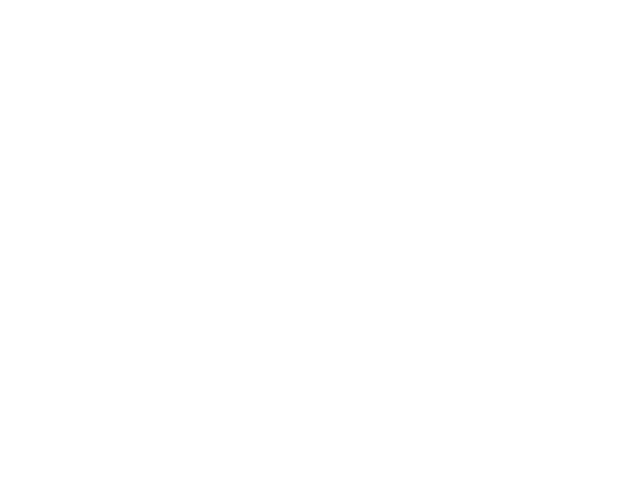

[26.42352151676916, 86.41861924647634]
Button(description='Hide', style=ButtonStyle())
Button(description='Show', style=ButtonStyle())
[28.161288322226508, 87.18784499438912]


In [5]:
from ipyleaflet import Map, basemaps, GeoData, Rectangle

import rasterio

## Create the map object
map = Map(zoom=2, basemap=basemaps.OpenStreetMap.HOT, scroll_wheel_zoom=True)

## Build a bounding box that contains the bounds of all the geotiff files.

# Start with the bounds of the first file
dataset = rasterio.open(geotiff_files[0])
bounds = dataset.bounds

for i, geotiff_file in enumerate(geotiff_files):
    dataset = rasterio.open(geotiff_file)

    # Join the bounds of the rest of the files
    bounds = rasterio.coords.BoundingBox(
        min(bounds.left, dataset.bounds.left),
        min(bounds.bottom, dataset.bounds.bottom),
        max(bounds.right, dataset.bounds.right),
        max(bounds.top, dataset.bounds.top),
    )

timeseries = Timeseries(map)

## Add the bounds to the map -- converting the rasterio.coords.BoundingBox object to ipyleaflet.Rectangle
bounds = ((bounds.bottom, bounds.left), (bounds.top, bounds.right))
map.add(Rectangle(bounds=bounds))
map.fit_bounds(bounds)


## Display the map
map

## Save NetCDF files

Convert the Timeseries object to a Xarray.DataArray object and save it to a NetCDF file.

In [ ]:
import xarray as xr

lon = [[lon for lon, lat in timeseries.coordinates]]
lat = [[lat for lon, lat in timeseries.coordinates]]
data = np.array([timeseries.data[timeseries.shown_series].to_numpy().transpose()])

ds = xr.DataArray(
    data = data,
    dims=['x', 'y', 'time'],
    name='Amplitude',
    coords=dict(
        lon=(['x', 'y'], lon),
        lat=(['x', 'y'], lat),
        time=timeseries.data['date']
    ),
    attrs=dict(
        description='InSAR amplitude',
        units='uncalibrated'
    )
)
ds.to_netcdf('test.nc')
ds